# <div style="text-align: center; font-weight: bold; font-size: 36px; color: black; margin-bottom: 20px;">Variable Selection in Linear Regression</div>

<div style="display: flex; margin-top: 30px;">
    <div style="flex: 1; padding-right: 20px;">
        <p style=" color: #228B22; margin-bottom: 20px; font-weight: bold;">Author: Lucas Ben | February 2024</p>
        <h3 style="color: #2f2f2f; margin-top: 0; font-weight: bold;">Summary</h3>
        <ul style="font-size: 16px; line-height: 1.6; margin-top: 10px; padding-left: 20px; font-weight: normal;">
            <li>Forward Stepwise Selection</li>
            <li>L1 Regularization (Lasso)</li>
            <li>L2 Regularization (Ridge)</li>
        </ul>
    </div>
    <div style="flex: 2; padding-left: 20px;">
        <!-- Your main content will go here -->
    </div>
</div>

<hr style="border: 0; height: 1px; background: linear-gradient(to right, transparent, #3498db, transparent); margin: 30px 0;">

## <div style="text-align: center; color: #000080; font-size: 30px; font-weight: bold;">Overview</div>
### <div style="text-align: center; color: black; font-size: 20px; font-weight: ;">In this notebook I use several methods for model and variable selection in a regression context, for a simulated data set.</div>

## <div style="text-align: center; color: #000080; font-size: 30px; font-weight: bold;">Why Use Linear Methods</div>

###  <div style="text-align: center; color: black; font-size: 20px; font-weight: ;">Linear methods often have advantages over non-linear methods in terms of interpretability and accuracy. The methods used in this analysis are OLS regression, stepwise selection, lasso regression, and ridge regression. Each method has advantages depending on the context. </div>

###  <div style="text-align: center; color: black; font-size: 20px; font-weight: ;">Lasso and ridge regression are methods that constrain the coefficient estimates or shrink them to towards zero. These techniques for shrinking regression coefficients allows us to fit a model with all p predictors and make decisions on which variables are most impactful.</div>

###  <div style="text-align: center; color: black; font-size: 20px; font-weight: ;">As always when building a model there is a bias-variance trade-off that must be struck.</div>


In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import cross_val_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale

## <div style="text-align: center; color: #000080; font-size: 30px; font-weight: bold;">Simulation</div>
### <div style="text-align: center; color: black; font-size: 20px; font-weight: ;">Creating an n x p matrix with randomly generated values from a standard normal distribution.</div>

In [28]:
np.random.seed(3463694)

n = 25
p = 10

# generating data
X = np.random.randn(n, p - 1)

# generating noise
x10 = X.mean(axis=1) + np.random.normal(0, 0.005, n) # linear combination of x1-x9
X = np.column_stack((X, x10))

# scaling data
X = scale(X)
beta = np.array([1, 0, 0, 0.002, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 0.1])
y = beta[0] + X @ beta[1:] + np.random.normal(0, 0.1, n)
data = pd.DataFrame(X, columns=[f"x{i}" for i in range(1, p + 1)])
data["y"] = y

print(data.head())

         x1        x2        x3        x4        x5        x6        x7  \
0 -1.818116  0.159627 -0.475266 -0.087894  0.846592 -0.543866  0.355694   
1  0.602733 -1.677197  0.248751 -0.007741  0.280065 -1.099146 -0.753738   
2 -0.990602  0.126583  0.165541  0.315324  0.864367  1.295816 -0.785653   
3  1.439035  1.303670  1.162563 -0.548963  1.782298  0.888056  1.339245   
4  1.454162 -1.916937 -0.335264  1.192748 -0.930117 -1.861332 -1.649050   

         x8        x9       x10         y  
0 -0.441615 -0.801687 -0.809849 -0.179433  
1  0.182834  1.321556 -0.051622  2.295470  
2 -0.021381  0.533483  0.559027  1.705268  
3  1.274130 -1.012363  1.952984  1.022465  
4 -0.058876 -1.363687 -1.597672 -0.679371  


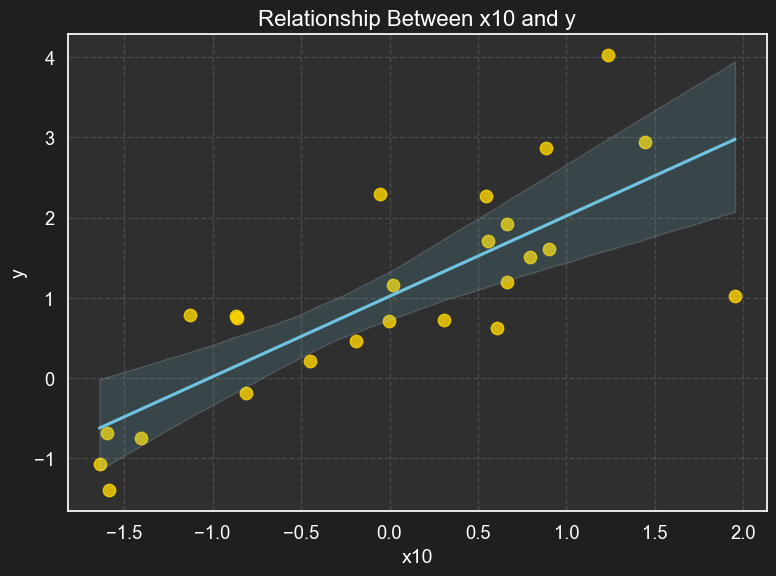

In [29]:
plt.figure(figsize=(8, 6))
sns.regplot(data=data, x="x10", y="y", scatter_kws={'s': 80}, line_kws={'color': '#6FC3DF'})
plt.title("Relationship Between x10 and y")
plt.tight_layout()
plt.show()

## <div style="text-align: center; color: #000080; font-size: 30px; font-weight: bold;">Fitting a Regression Model</div>
### <div style="text-align: center; color: black; font-size: 20px; font-weight: ;">Fitting a multiple regression model to the data with y as the output and all other variables as inputs.</div>

In [45]:
# OLS
X_sm = sm.add_constant(X)
model_ols = sm.OLS(y, X_sm).fit()
print(model_ols.summary()) # printing estimated regression parameters

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     304.5
Date:                Sun, 06 Apr 2025   Prob (F-statistic):           1.37e-14
Time:                        14:08:02   Log-Likelihood:                 25.884
No. Observations:                  25   AIC:                            -29.77
Df Residuals:                      14   BIC:                            -16.36
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0189      0.023     44.367      0.0

## <div style="text-align: center; color: #000080; font-size: 30px; font-weight: bold;">Forward Stepwise Selection</div>

### <div style="text-align: center; color: black; font-size: 20px; font-weight: ;">Forward stepwise selection begins with a model containing no predictors, and then adds predictors to the model one at a time until all of the predictors are in the model.</div>

In [6]:
# forward stepwise selection
sfs = SFS(
    LinearRegression(),
    k_features=(1, p),
    forward=True,
    scoring="neg_mean_squared_error",
    cv=5,
)
sfs.fit(X, y)

# best model using CV error
best_subset = sfs.k_score_
print(f"Best subset: {best_subset}")

Best subset: -0.014160208163454868


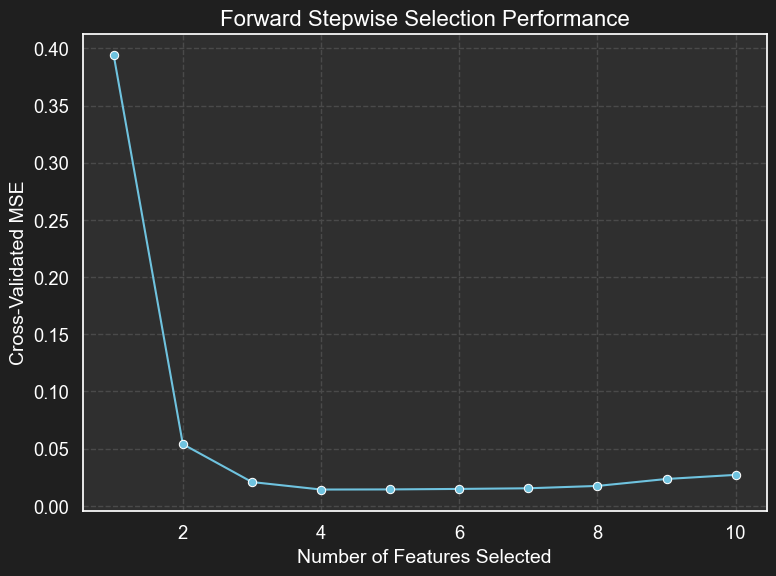

In [44]:
# creating scree plot
subset_sizes = list(sfs.subsets_.keys())
cv_scores = [-sfs.subsets_[k]['avg_score'] for k in subset_sizes]  

plt.figure(figsize=(8, 6))
sns.lineplot(x=subset_sizes, y=cv_scores, marker='o', color="#6FC3DF")
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validated MSE")
plt.title("Forward Stepwise Selection Performance")
plt.grid(True)
plt.tight_layout()
plt.show()

## <div style="text-align: center; color: #000080; font-size: 30px; font-weight: bold;">Forward Stepwise Selection Analysis</div>


<div style="font-size: 20px; color: black; font-weight: normal;">
• The negative MSE score (-0.01416) follows scikit-learn's convention where higher values indicate better performance - when converted to positive MSE, lower values are better. Low MSE indicates strong predictive accuracy. <br>
• MSE drops sharply at 2-3 features, indicating these variables contain the most information. Performance gain flattens after 3 features, suggesting additional variables provide marginal benefit.<br>
<br>
</div>

## <div style="text-align: center; color: #000080; font-size: 30px; font-weight: bold;">L1 Regularization</div>

### <div style="text-align: center; color: black; font-size: 20px; font-weight: ;">The lasso is a tool for variable selection that shrinks some coefficients exactly equal to zero. Lasso has high interpretability and low flexibility.</div>

In [13]:
# L1 regularization
lasso_cv = LassoCV(
    alphas=np.logspace(-3, 0, 50), 
    cv=5,
    max_iter=10000, # set higher iteration value to help with convergence
    tol=1e-4,      
    random_state=42
).fit(X, y)


print(f"Best lambda: {lasso_cv.alpha_}")
print("Coefficients:", lasso_cv.coef_)

Best lambda: 0.012648552168552958
Coefficients: [-0.         -0.          0.         -0.          0.          0.07231088
  0.11725989  0.51827507  1.01866149  0.05527102]


## <div style="text-align: center; color: #000080; font-size: 30px; font-weight: bold;">Lasso Results</div>

<div style="font-size: 20px; color: black; font-weight: normal;">
• Best λ = 0.0126 <br>
• Features selected are (x6-x10).
</div>

## <div style="text-align: center; color: #000080; font-size: 30px; font-weight: bold;">L2 Regularization</div>

### <div style="text-align: center; color: black; font-size: 20px; font-weight: ;">Ridge regression is similar to OLS but the coefficients are estimated by minimizing a penalized RSS. This penalty is crucial to the effectiveness of the model.</div>

In [9]:
lambdas = 2.0 ** np.arange(-15, 3)

# L2 regularization
ridge_cv = RidgeCV(alphas=np.logspace(-3, 0, 50), cv=5).fit(X, y)

print(f"Best lambda: {ridge_cv.alpha_}")
print("Coefficients:", ridge_cv.coef_)

Best lambda: 0.21209508879201905
Coefficients: [-0.08374158 -0.08394964 -0.07362679 -0.07058138 -0.08960078 -0.00755903
  0.0698025   0.45199376  0.91774577  0.35504448]


## <div style="text-align: center; color: #000080; font-size: 30px; font-weight: bold;">Ridge Regression Results</div>


<div style="font-size: 20px; color: black; font-weight: normal;">
• Best λ = 0.212  <br>
• All coefficients retained but shrunk, with x9 (0.918) and x8 (0.452) showing strongest signals. Noise (x1-x5) were suppressed near zero.
</div>

## <div style="text-align: center; color: #000080; font-size: 30px; font-weight: bold;">Model Performance</div>

In [18]:
ridge_scores = cross_val_score(
    Ridge(alpha=ridge_cv.alpha_),
    X, y,
    cv=5,
    scoring="neg_mean_squared_error"
)

lasso_scores = cross_val_score(
    Lasso(alpha=lasso_cv.alpha_, max_iter=10000),
    X, y,
    cv=5,
    scoring="neg_mean_squared_error"
)

ridge_error = -ridge_scores.mean()
lasso_error = -lasso_scores.mean()

print(f"Optimized Ridge CV Error: {ridge_error:.5f}")
print(f"Optimized Lasso CV Error: {lasso_error:.5f}")
print(f"\nRidge optimal alpha: {ridge_cv.alpha_:.6f}")
print(f"Lasso optimal alpha: {lasso_cv.alpha_:.6f}")

Optimized Ridge CV Error: 0.02352
Optimized Lasso CV Error: 0.01614

Ridge optimal alpha: 0.212095
Lasso optimal alpha: 0.012649


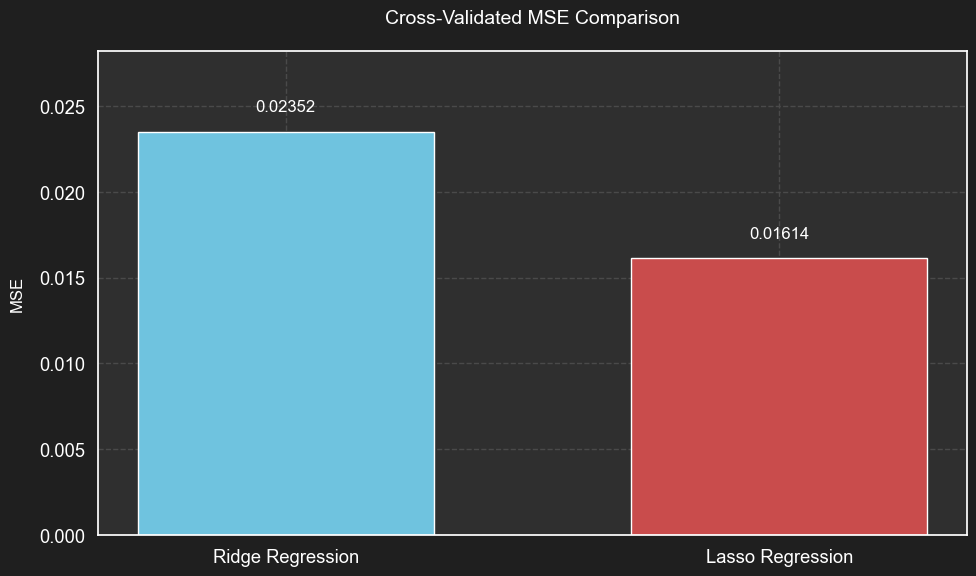

In [43]:
# model output
ridge_error = 0.02352
lasso_error = 0.01614

models = ['Ridge Regression', 'Lasso Regression']
errors = [ridge_error, lasso_error]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, errors, color=['#6FC3DF', '#C94C4C'], width=0.6)
plt.title('Cross-Validated MSE Comparison', fontsize=14, pad=20)
plt.ylabel('MSE', fontsize=12, labelpad=10)
plt.ylim(0, max(errors)*1.2)  

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., 
             height + 0.001, 
             f'{height:.5f}',
             ha='center', 
             va='bottom', 
             fontsize=12)

plt.tight_layout()  
plt.show()

## <div style="text-align: center; color: #000080; font-size: 30px; font-weight: bold;">Analysis</div>

### <div style="text-align: center; color: black; font-size: 20px;">The Lasso model achieved superior predictive performance (λ=0.0126, MSE: 0.01614) compared to Ridge (λ=0.2121, MSE: 0.02352), demonstrating a 31% lower error. Lasso's L1 penalty effectively eliminated noise variables (x1-x5) while Ridge's L2 penalty only shrank them.</div>

<div style="font-size: 18px; color: black; margin-left: 20px;">
• <strong>Performance Gap</strong>: Lasso's 31% lower MSE confirms its advantage for sparse data structures.<br>

• <strong>Variable Selection</strong>: Lasso eliminated noise (x1-x5 → 0) while Ridge retained them with minor shrinkage.
</div>